In [1]:
## anaconda3 (Python 3.12.0) Kernel
import numpy as np
import csv
# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import numpy as np
from collections import defaultdict

# Load Pairs Data


In [88]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_55010/734353408.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [89]:
with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]

top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]
rollingWindow = 262
cutLossSd = 2

for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_55010/3045906102.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


## Make indicators and spread stationary around 0
Deduct the mean from all values to translate to 0 axis

In [90]:
workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[pair].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['spread','1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

workingPairOutcome[top_keys[5]][-5:]

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0]])

In [91]:
# due to spikey-ness of reward around 0, scale from -1 to 1 and give more rewards above 1, 2, 3
dailypnl_sd = 0.018390515013803736 # see /Users/ju/Projects/00_SMU/mqf_practice/QF634_Applied_Quantitative_Research_Methods/QF634 Project/Pair Trading/03_project_state_space_analysis.ipynb for SD derivation

# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Q Value table

In [6]:
def get_baseline(env, trained_agent, max_steps_per_episode, pair_idx):
    env.reset(pair_idx)
    total_reward = 0
    env.current_step = 261
    env.last_step = 2868

    for step in range(max_steps_per_episode):
        state = workingPairOutcome[top_keys[pair_idx]][env.current_step]
        state_index = env.valid_states.index(tuple(state))
        action_index = np.argmax(trained_agent.Q[state_index])
        action = trained_agent.index_to_action[action_index]
        _, reward, done = env.step(action,pair_idx)
        total_reward += reward
            
        if done:
            break

    # print(trained_agent.Q)

    print(f"{pair_idx+1}. {top_keys[pair_idx]}: Reward: {total_reward:.5f}, step {step}")
    return total_reward

class PairTradeEnv1:
    def __init__(self):
        # Initialize environment variables and parameters
        self.num_actions = 3
        self.valid_states = [
            (0, 0, 0, 1, 0, 0),
            (0, 0, 0, 1, 1, 0),
            (0, 0, 0, 1, 1, 1),
            (0, 0, 1, 0, 0, 0),
            (0, 1, 1, 0, 0, 0),
            (1, 1, 1, 0, 0, 0),
            (0, 0, 0, 0, 0, 0),
        ]  # Define valid states
        self.state_mapping = {
            i: state for i, state in enumerate(self.valid_states)
        }
        self.earliest_step = 261  # Hot start
        self.last_step = 2868

        self.state = np.zeros(6)
        self.current_step = self.earliest_step

    def reset(self, pair_idx):
        # Reset the environment to its initial state
        self.current_step = self.earliest_step
        self.state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        return self.state

    def step(self, action, pair_idx):
        # Advance the time step
        self.current_step += 1
        next_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        reward = self.calculate_reward(action, pair_idx)
        done = self.current_step >= self.last_step
        return next_state, reward, done

    def calculate_reward(self, position, pair_idx):
        """
        Calculate reward based on the previous day's return.
        """
        pair = validPairsList[pair_idx]
        position_0 = position
        position_1 = position * -1
        dailypnl = position_0 * return_df[f'{pair[0]}'].iloc[self.current_step] \
            + position_1 * return_df[f'{pair[1]}'].iloc[self.current_step]

        return dailypnl

class Agent:
    def __init__(self, env, num_states, num_actions, batch_size, alpha=0.1, gamma=0.9, epsilon=0.5, epsilon_decay=0.95, buffer_size = 10000):
        self.env = env
        self.num_actions = num_actions
        self.num_states = num_states
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        # set indices for q table
        self.action_to_index = {-1: 0, 0: 1, 1: 2}
        self.index_to_action = {0: -1, 1: 0, 2: 1}
        self.Q = np.zeros((num_states, num_actions))
        # replay memory
        self.replay_buffer = []
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.state_counts = np.zeros(len(self.env.valid_states))
        self.batch = []

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action_index = np.random.randint(self.num_actions)
        else:
            state_index = self.env.valid_states.index(tuple(state))
            action_index = np.argmax(self.Q[state_index])
        return self.index_to_action[action_index]

    def update_Q_from_buffer(self):
        if len(self.replay_buffer) < self.buffer_size:
            return
        # get counts of each state
        state_counts = np.bincount([state_index for state_index, _, _, _ in self.replay_buffer], 
                                   minlength=len(self.env.valid_states))
        state_probabilities = state_counts / state_counts.sum()
        # equally represent all states in a batch
        batch = []
        for _ in range(self.batch_size):
            sampled_state_index = np.random.choice(len(self.env.valid_states), p=state_probabilities)
            filtered_transitions = [transition for transition in self.replay_buffer if transition[0] == sampled_state_index]
            if not filtered_transitions:
                return  
            batch.append(filtered_transitions[np.random.choice(len(filtered_transitions))])
        # train based on resampled batch
        for state_index, action, reward, next_state_index in batch:
            reward /= dailypnl_sd
            self.Q[state_index, self.action_to_index[action]] += self.alpha * (
                reward + self.gamma * np.max(self.Q[next_state_index])
                - self.Q[state_index, self.action_to_index[action]]
            )
            self.state_counts[state_index] += 1

    def learn(self, num_episodes):
        step_count = 0
        for episode in range(num_episodes):
            for pair_idx in range(len(top_keys)):
                state = self.env.reset(pair_idx)
                done = False

                while not done:
                    action = self.choose_action(state)

                    next_state, reward, done = self.env.step(action, pair_idx)
                    state_index = self.env.valid_states.index(tuple(state))
                    next_state_index = self.env.valid_states.index(tuple(next_state))

                    self.replay_buffer.append((state_index, action, reward, next_state_index))
                    if len(self.replay_buffer) > self.buffer_size:
                        self.replay_buffer.pop(0)

                    if step_count%self.batch_size==0:
                        self.update_Q_from_buffer()
                    
                    step_count += 1
                    state = next_state
            self.epsilon = max(0.3, self.epsilon*self.epsilon_decay)
            if episode%5==0:
                print(self.epsilon)
            


# Experiments
## Gamma = 0

In [160]:
num_epochs = 3
num_episodes = 10
gamma = 0

ls_epoch_reward = []
for epoch in range(num_epochs):
    # instantiate
    env = PairTradeEnv1()
    agent = Agent(env=env,
                num_states=len(env.valid_states), 
                num_actions=env.num_actions, 
                batch_size=len(env.valid_states)*100, 
                alpha=0.01, 
                gamma=gamma, 
                epsilon_decay=0.87,
                epsilon=1, 
                buffer_size =len(top_keys)*1_000)
    # train
    agent.learn(num_episodes)
    # evaluate
    total_train_return = 0
    for idx, _ in enumerate(top_keys):
        total_train_return += get_baseline(env, agent, 3000, pair_idx=idx)

    ls_epoch_reward.append(total_train_return/len(top_keys))

print(f"Epoch Total Ave Reward: {ls_epoch_reward}")
print(f"Epoch Ave Ave Reward: \t{np.array(ls_epoch_reward).mean():.5f}")
print(f"Epoch SD  Ave Reward: \t{np.array(ls_epoch_reward).std():.5f} ")

0.87
1. 6503 JP Equity 7269 JP Equity: Reward: 0.08902, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 0.54047, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: -0.20621, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 0.58451, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 0.86679, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: 0.27574, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 0.62339, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 0.20467, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 0.60620, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 0.41448, step 2606
0.87
1. 6503 JP Equity 7269 JP Equity: Reward: 1.32099, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 1.60975, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.80435, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 0.36728, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 0.13018, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.03102, step 2606
7. 4684 JP 

In [162]:
df = pd.DataFrame(agent.Q, index=env.valid_states, columns=[-1, 0, 1])
df['mean_reversion'] = [0,1,0,0,-1,0,0]
df['position'] = df[[-1, 0, 1]].idxmax(axis=1)

df.to_csv(f"q_table_gamma{agent.gamma}_{datetime.now().strftime("%Y%m%d_%H%M")}.csv")
dict_policy_actions = dict(df.position)
df

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-0.086297,0.0,-0.003348,0,0
"(0, 0, 0, 1, 1, 0)",-0.065741,0.0,0.032649,1,1
"(0, 0, 0, 1, 1, 1)",-0.134188,0.0,0.187067,0,1
"(0, 0, 1, 0, 0, 0)",0.005202,0.0,-0.113009,0,-1
"(0, 1, 1, 0, 0, 0)",0.043132,0.0,-0.050129,-1,-1
"(1, 1, 1, 0, 0, 0)",0.100183,0.0,0.078754,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.0,0.000000,0,-1


table is taking a long time to generalise. using one pair is not good enough to get any poistioning as everything is flat. only after adding all 10 pairs then performance churns out shorting on 1 SD high cross.

Experiment: try making gamma 0.1, Q table should closely mimic the state space analysis table with strong mean reversion tendency. This is not what we see. and it even has Q values opposite to state space.

In [163]:
workingPairQresults = {}
for pair_idx in range(len(top_keys)):
    df = pd.DataFrame(workingPairOutcome[top_keys[pair_idx]], columns=dummy_df.columns)

    # Assign policy values using the dictionary
    df['position'] = df.apply(lambda row: dict_policy_actions.get(tuple(row), np.nan), axis=1)
    df[df.isna().any(axis=1)]
    pair = validPairsList[pair_idx]
    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values \
                    + df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values
    df['cumpnl'] = df['dailypnl'].cumsum()
    workingPairQresults[top_keys[pair_idx]] = df

total_q_return = 0
total_train_q_return = 0
total_test_q_return = 0

for pair in top_keys:
    total_q_return += workingPairQresults[pair]['cumpnl'].iloc[-2]
    total_train_q_return += workingPairQresults[pair]['cumpnl'].iloc[2868-2]

print("="*10, "Absolute", "="*10)
print(f"total return \t\t{total_q_return/len(top_keys):.5f}")
print(f"total train return \t{total_train_q_return/len(top_keys):.5f}")
print(f"total test return \t{(total_q_return - total_train_q_return)/len(top_keys):.5f}")
print("="*10, "Normalised", "="*10)
print(f"total return \t\t{total_q_return/len(top_keys)/(2979-261):.5f}")
print(f"total train return \t{total_train_q_return/len(top_keys)/(2868-261):.5f}")
print(f"total test return \t{(total_q_return - total_train_q_return)/len(top_keys)/(2979-2868):.5f}")

========== Absolute ==========
total return 		1.59523
total train return 	1.46979
total test return 	0.12545
========== Normalised ==========
total return 		0.00059
total train return 	0.00056
total test return 	0.00113


## Gamma > 0

In [8]:
num_epochs = 4
num_episodes = 20
gamma = 0.1
# ls_gamma = [.01, .1, .5, .9]

ls_epoch_reward = []
for epoch in range(num_epochs):
    # instantiate
    env = PairTradeEnv1()
    agent = Agent(env=env,
                num_states=len(env.valid_states), 
                num_actions=env.num_actions, 
                batch_size= len(top_keys)*100, 
                alpha=0.01, 
                gamma=gamma, 
                epsilon=1,
                epsilon_decay=0.972,
                buffer_size = len(top_keys)*1_000)
    print(agent.gamma, env.current_step)
    # train
    agent.learn(num_episodes)
    # evaluate
    total_train_return = 0
    for idx, _ in enumerate(top_keys):
        total_train_return += get_baseline(env, agent, 3000, pair_idx=idx)

    ls_epoch_reward.append(total_train_return/len(top_keys))

print(f"Epoch Total Ave Reward: {ls_epoch_reward}")
print(f"Epoch Ave Ave Reward: \t{np.array(ls_epoch_reward).mean():.5f}")
print(f"Epoch SD  Ave Reward: \t{np.array(ls_epoch_reward).std():.5f} ")

0.1 261
0.972
0.8433300770596822
0.7316930235323966
0.6348340883946585
1. 6503 JP Equity 7269 JP Equity: Reward: 2.45768, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 1.84411, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.35446, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 0.73990, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 1.55099, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.03470, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 1.45273, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 1.10531, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 1.56041, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 1.84292, step 2606
0.1 261
0.972
0.8433300770596822
0.7316930235323966
0.6348340883946585
1. 6503 JP Equity 7269 JP Equity: Reward: -0.23593, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 1.18805, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.19581, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 1.19846, step 2606
5

In [9]:
df = pd.DataFrame(agent.Q, index=env.valid_states, columns=[-1, 0, 1])
df['mean_reversion'] = [0,1,0,0,-1,0,0]
df['position'] = df[[-1, 0, 1]].idxmax(axis=1)

df.to_csv(f"q_table_gamma{agent.gamma}_{datetime.now().strftime("%Y%m%d_%H%M")}.csv")
dict_policy_actions = dict(df.position)
df

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-0.058937,0.004462,0.072929,0,1
"(0, 0, 0, 1, 1, 0)",-0.151937,0.005675,0.036338,1,1
"(0, 0, 0, 1, 1, 1)",-0.098055,0.005156,-0.059014,0,0
"(0, 0, 1, 0, 0, 0)",0.167834,0.004741,0.014672,0,-1
"(0, 1, 1, 0, 0, 0)",0.020462,0.002615,-0.017482,-1,-1
"(1, 1, 1, 0, 0, 0)",0.186034,0.006866,0.029779,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0,-1


In [10]:
workingPairQresults = {}
for pair_idx in range(len(top_keys)):
    df = pd.DataFrame(workingPairOutcome[top_keys[pair_idx]], columns=dummy_df.columns)

    # Assign policy values using the dictionary
    df['position'] = df.apply(lambda row: dict_policy_actions.get(tuple(row), np.nan), axis=1)
    df[df.isna().any(axis=1)]
    pair = validPairsList[pair_idx]
    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values \
                    + df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values
    df['cumpnl'] = df['dailypnl'].cumsum()
    workingPairQresults[top_keys[pair_idx]] = df

total_q_return = 0
total_train_q_return = 0
total_test_q_return = 0

for pair in top_keys:
    total_q_return += workingPairQresults[pair]['cumpnl'].iloc[-2]
    total_train_q_return += workingPairQresults[pair]['cumpnl'].iloc[2868-2]

print("="*10, "Absolute", "="*10)
print(f"total return \t\t{total_q_return/len(top_keys):.5f}")
print(f"total train return \t{total_train_q_return/len(top_keys):.5f}")
print(f"total test return \t{(total_q_return - total_train_q_return)/len(top_keys):.5f}")
print("="*10, "Normalised", "="*10)
print(f"total return \t\t{total_q_return/len(top_keys)/(2979-261):.5f}")
print(f"total train return \t{total_train_q_return/len(top_keys)/(2868-261):.5f}")
print(f"total test return \t{(total_q_return - total_train_q_return)/len(top_keys)/(2979-2868):.5f}")

========== Absolute ==========
total return 		1.59944
total train return 	1.41070
total test return 	0.18874
========== Normalised ==========
total return 		0.00059
total train return 	0.00054
total test return 	0.00170


# Saved results

## Reward update only (NO Bellman equation)

In [122]:
result = pd.read_csv("11_q_table_alphagamma0_20241215_1331.csv").drop(columns=['Unnamed: 0'])
result.columns = result.columns.get_level_values(0)
result.index = env.valid_states
result

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-229.505883,0.0,237.821704,0,1
"(0, 0, 0, 1, 1, 0)",-756.680897,0.0,897.857634,1,1
"(0, 0, 0, 1, 1, 1)",-299.155432,0.0,475.504548,0,1
"(0, 0, 1, 0, 0, 0)",568.071953,0.0,-272.146199,0,-1
"(0, 1, 1, 0, 0, 0)",340.999384,0.0,-716.541961,-1,-1
"(1, 1, 1, 0, 0, 0)",631.879445,0.0,-559.831341,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.0,0.000000,0,-1


In [123]:
env = PairTradeEnv1()
agent1 = Agent(env=env,
            num_states=len(env.valid_states), 
            num_actions=env.num_actions, 
            batch_size= 10, 
            alpha=0.1, 
            gamma=0, 
            epsilon_decay=0.987,
            epsilon=0, 
            buffer_size = 10000)
agent1.Q = result[['-1', '0', '1']].values
# evaluate
total_train_return = 0
for idx, _ in enumerate(top_keys):
    total_train_return += get_baseline(env, agent1, 3000, pair_idx=idx)
f"Average Train return {total_train_return/len(top_keys):.3f}"

1. 6503 JP Equity 7269 JP Equity: Reward: 2.03332, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 2.30741, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.38158, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 2.76483, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 1.82381, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.36498, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 1.91586, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 2.47427, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 1.51373, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 1.53074, step 2606


'Average Train return 1.638'

==================== Baseline Return Train ====================
Mean: 			1.63806
Mean (ave daily return): 0.00063
==================== Baseline Return Test ====================
Mean: 			0.18682
Mean (ave daily return): 0.00168


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_55010/1324668500.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]


<Axes: xlabel='Date'>

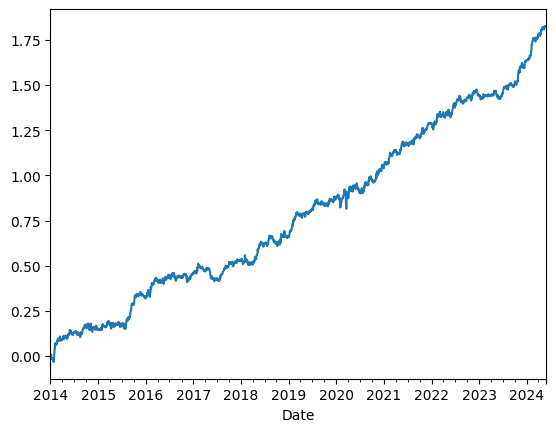

In [124]:
# collect solution actions and map to daily returns
model_solution = dict(result.position)
model_solution[(0, 0, 0, 0, 0, 0)]= 0
def map_row(row):
    return model_solution.get(tuple(row), 0) 
result_dict = {
    key: {
        "state": value,
        "action": np.append(
            np.apply_along_axis(map_row, 1, value)[:-1], 0  # Set last entry to 0
        )
    }
    for key, value in workingPairOutcome.items()
}
for key, pair in zip(top_keys, validPairsList):
    dummy_df = pairsOutcome[key]
    dummy_df['position'] = result_dict[key]['action']
    dummy_df[f"{pair[0]} position"] = dummy_df['position']
    dummy_df[f"{pair[1]} position"] = dummy_df['position'] * -1

    dummy_df['dailypnl'] = dummy_df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values  + dummy_df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values
    dummy_df['cumpnl'] = dummy_df['dailypnl'].cumsum()
    pairsOutcome[key] = dummy_df

# combine daily returns from all pair trades
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]
df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
# obtain train and test returns
baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]
baseline_test_mean_return = df_daily_returns.iloc[2869:].cumsum().iloc[-2].mean()
print("="*20, "Baseline Return Train","="*20)
print(f"Mean: \t\t\t{baseline_train_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_train_mean_return/(2868-261):.5f}")
print("="*20, "Baseline Return Test","="*20)
print(f"Mean: \t\t\t{baseline_test_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_test_mean_return/(2979-2868):.5f}")
# print baseline restults to csv
df_export = df_daily_returns.mean(axis=1).cumsum()[261:]
df_export.to_csv("32_nobellman_return.csv")
df_export.plot()

## Bellman Equation with gamma > 0 

In [125]:
result = pd.read_csv("12_q_table_gamma0_20241215_1357.csv").drop(columns=['Unnamed: 0'])
result.columns = result.columns.get_level_values(0)
result.index = env.valid_states
result

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-0.086297,0.0,-0.003348,0,0
"(0, 0, 0, 1, 1, 0)",-0.065741,0.0,0.032649,1,1
"(0, 0, 0, 1, 1, 1)",-0.134188,0.0,0.187067,0,1
"(0, 0, 1, 0, 0, 0)",0.005202,0.0,-0.113009,0,-1
"(0, 1, 1, 0, 0, 0)",0.043132,0.0,-0.050129,-1,-1
"(1, 1, 1, 0, 0, 0)",0.100183,0.0,0.078754,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.0,0.000000,0,-1


In [126]:
env = PairTradeEnv1()
agent1 = Agent(env=env,
            num_states=len(env.valid_states), 
            num_actions=env.num_actions, 
            batch_size= 10, 
            alpha=0.1, 
            gamma=0, 
            epsilon_decay=0.987,
            epsilon=0, 
            buffer_size = 10000)
agent1.Q = result[['-1', '0', '1']].values
# evaluate
total_train_return = 0
for idx, _ in enumerate(top_keys):
    total_train_return += get_baseline(env, agent1, 3000, pair_idx=idx)
f"Average Train return {total_train_return/len(top_keys):.3f}"

1. 6503 JP Equity 7269 JP Equity: Reward: 1.46498, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 2.19023, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.60653, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 2.57852, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 1.11340, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.36314, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 1.35080, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 2.41147, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 1.55658, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 1.66204, step 2606


'Average Train return 1.457'

==================== Baseline Return Train ====================
Mean: 			1.45714
Mean (ave daily return): 0.00056
==================== Baseline Return Test ====================
Mean: 			0.12370
Mean (ave daily return): 0.00111


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_55010/2290566191.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]


<Axes: xlabel='Date'>

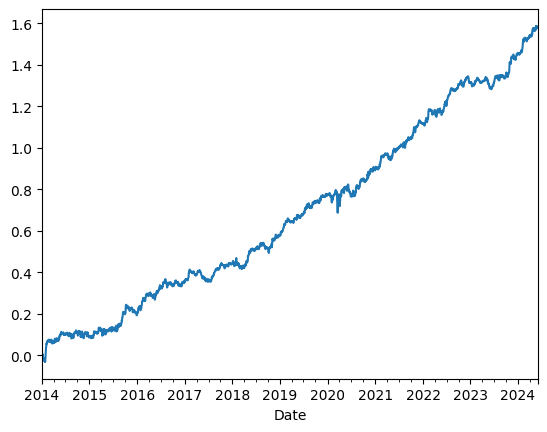

In [127]:
# collect solution actions and map to daily returns
model_solution = dict(result.position)
model_solution[(0, 0, 0, 0, 0, 0)]= 0
def map_row(row):
    return model_solution.get(tuple(row), 0) 
result_dict = {
    key: {
        "state": value,
        "action": np.append(
            np.apply_along_axis(map_row, 1, value)[:-1], 0  # Set last entry to 0
        )
    }
    for key, value in workingPairOutcome.items()
}
for key, pair in zip(top_keys, validPairsList):
    dummy_df = pairsOutcome[key]
    dummy_df['position'] = result_dict[key]['action']
    dummy_df[f"{pair[0]} position"] = dummy_df['position']
    dummy_df[f"{pair[1]} position"] = dummy_df['position'] * -1

    dummy_df['dailypnl'] = dummy_df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values  + dummy_df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values
    dummy_df['cumpnl'] = dummy_df['dailypnl'].cumsum()
    pairsOutcome[key] = dummy_df

# combine daily returns from all pair trades
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]
df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
# obtain train and test returns
baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]
baseline_test_mean_return = df_daily_returns.iloc[2869:].cumsum().iloc[-2].mean()
print("="*20, "Baseline Return Train","="*20)
print(f"Mean: \t\t\t{baseline_train_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_train_mean_return/(2868-261):.5f}")
print("="*20, "Baseline Return Test","="*20)
print(f"Mean: \t\t\t{baseline_test_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_test_mean_return/(2979-2868):.5f}")
# print baseline restults to csv
df_export = df_daily_returns.mean(axis=1).cumsum()[261:]
df_export.to_csv("33_bellman_gamma0_return.csv")
df_export.plot()

## Bellman Equation with Gamma = 0.1, Alpha = 0.1

In [128]:
result = pd.read_csv("13_q_table_gamma0.1_20241215_1514.csv").drop(columns=['Unnamed: 0'])
result.columns = result.columns.get_level_values(0)
result.index = env.valid_states
result

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-0.058937,0.004462,0.072929,0,1
"(0, 0, 0, 1, 1, 0)",-0.151937,0.005675,0.036338,1,1
"(0, 0, 0, 1, 1, 1)",-0.098055,0.005156,-0.059014,0,0
"(0, 0, 1, 0, 0, 0)",0.167834,0.004741,0.014672,0,-1
"(0, 1, 1, 0, 0, 0)",0.020462,0.002615,-0.017482,-1,-1
"(1, 1, 1, 0, 0, 0)",0.186034,0.006866,0.029779,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0,-1


In [129]:
env = PairTradeEnv1()
agent1 = Agent(env=env,
            num_states=len(env.valid_states), 
            num_actions=env.num_actions, 
            batch_size= 10, 
            alpha=0.1, 
            gamma=0, 
            epsilon_decay=0.987,
            epsilon=0, 
            buffer_size = 10000)
agent1.Q = result[['-1', '0', '1']].values
# evaluate
total_train_return = 0
for idx, _ in enumerate(top_keys):
    total_train_return += get_baseline(env, agent1, 3000, pair_idx=idx)
f"Average Train return {total_train_return/len(top_keys):.3f}"

1. 6503 JP Equity 7269 JP Equity: Reward: 2.07455, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 1.98566, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.32617, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 2.34702, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 1.66500, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.32307, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 1.32468, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 2.21454, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 1.02894, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 1.34147, step 2606


'Average Train return 1.398'

==================== Baseline Return Train ====================
Mean: 			1.39850
Mean (ave daily return): 0.00054
==================== Baseline Return Test ====================
Mean: 			0.18655
Mean (ave daily return): 0.00168


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_55010/2125458990.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]


<Axes: xlabel='Date'>

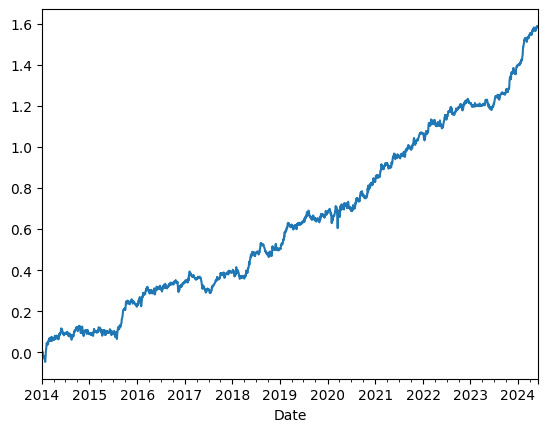

In [130]:
# collect solution actions and map to daily returns
model_solution = dict(result.position)
model_solution[(0, 0, 0, 0, 0, 0)]= 0
def map_row(row):
    return model_solution.get(tuple(row), 0) 
result_dict = {
    key: {
        "state": value,
        "action": np.append(
            np.apply_along_axis(map_row, 1, value)[:-1], 0  # Set last entry to 0
        )
    }
    for key, value in workingPairOutcome.items()
}
for key, pair in zip(top_keys, validPairsList):
    dummy_df = pairsOutcome[key]
    dummy_df['position'] = result_dict[key]['action']
    dummy_df[f"{pair[0]} position"] = dummy_df['position']
    dummy_df[f"{pair[1]} position"] = dummy_df['position'] * -1

    dummy_df['dailypnl'] = dummy_df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values  + dummy_df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values
    dummy_df['cumpnl'] = dummy_df['dailypnl'].cumsum()
    pairsOutcome[key] = dummy_df

# combine daily returns from all pair trades
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]
df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
# obtain train and test returns
baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]
baseline_test_mean_return = df_daily_returns.iloc[2869:].cumsum().iloc[-2].mean()
print("="*20, "Baseline Return Train","="*20)
print(f"Mean: \t\t\t{baseline_train_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_train_mean_return/(2868-261):.5f}")
print("="*20, "Baseline Return Test","="*20)
print(f"Mean: \t\t\t{baseline_test_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_test_mean_return/(2979-2868):.5f}")
# print baseline restults to csv
df_export = df_daily_returns.mean(axis=1).cumsum()[261:]
df_export.to_csv("34_bellman_gamma001_return.csv")
df_export.plot()

In [131]:
result = pd.read_csv("12_q_table_gamma0_20241215_1357.csv").drop(columns=['Unnamed: 0'])
result.columns = result.columns.get_level_values(0)
result.index = env.valid_states
result

,-1,0,1,mean_reversion,position
"(0, 0, 0, 1, 0, 0)",-0.086297,0.0,-0.003348,0,0
"(0, 0, 0, 1, 1, 0)",-0.065741,0.0,0.032649,1,1
"(0, 0, 0, 1, 1, 1)",-0.134188,0.0,0.187067,0,1
"(0, 0, 1, 0, 0, 0)",0.005202,0.0,-0.113009,0,-1
"(0, 1, 1, 0, 0, 0)",0.043132,0.0,-0.050129,-1,-1
"(1, 1, 1, 0, 0, 0)",0.100183,0.0,0.078754,0,-1
"(0, 0, 0, 0, 0, 0)",0.000000,0.0,0.000000,0,-1


In [132]:
env = PairTradeEnv1()
agent1 = Agent(env=env,
            num_states=len(env.valid_states), 
            num_actions=env.num_actions, 
            batch_size= 10, 
            alpha=0.1, 
            gamma=0, 
            epsilon_decay=0.987,
            epsilon=0, 
            buffer_size = 10000)
agent1.Q = result[['-1', '0', '1']].values
# evaluate
total_train_return = 0
for idx, _ in enumerate(top_keys):
    total_train_return += get_baseline(env, agent1, 3000, pair_idx=idx)
total_train_return/len(top_keys)

f"Average Train return {total_train_return/len(top_keys):.3f}"

1. 6503 JP Equity 7269 JP Equity: Reward: 1.46498, step 2606
2. 6326 JP Equity 6954 JP Equity: Reward: 2.19023, step 2606
3. 8053 JP Equity 8058 JP Equity: Reward: 0.60653, step 2606
4. 4901 JP Equity 9613 JP Equity: Reward: 2.57852, step 2606
5. 6988 JP Equity 7267 JP Equity: Reward: 1.11340, step 2606
6. 4901 JP Equity 6702 JP Equity: Reward: -0.36314, step 2606
7. 4684 JP Equity 7832 JP Equity: Reward: 1.35080, step 2606
8. 7267 JP Equity 8306 JP Equity: Reward: 2.41147, step 2606
9. 7267 JP Equity 8801 JP Equity: Reward: 1.55658, step 2606
10. 4519 JP Equity 7532 JP Equity: Reward: 1.66204, step 2606


'Average Train return 1.457'

# Verify results

In [133]:
pair = validPairsList[0]
df = pairsOutcome[top_keys[0]].copy()
df['position'] = df.apply(lambda row: 1 if row['spread'] < row['mid'] else -1, axis=1)

df[f'{pair[0]} position'] = df['position']
df[f'{pair[1]} position'] = df['position'] * -1
df['dailypnl'] = df['position']*return_df[f'{pair[0]}'].shift(-1) - df['position']*return_df[f'{pair[1]}'].shift(-1)
df['cumpnl'] = df['dailypnl'].cumsum()


In [134]:
df.apply(lambda row: 1 if row['spread'] < row['mid'] else -1, axis=1)

Date
2013-01-01   -1
2013-01-02   -1
2013-01-03   -1
2013-01-04   -1
2013-01-07   -1
             ..
2024-05-27   -1
2024-05-28   -1
2024-05-29   -1
2024-05-30   -1
2024-05-31   -1
Length: 2979, dtype: int64

In [135]:
df['cumpnl'].describe()

count    2978.000000
mean        0.721590
std         0.605643
min        -0.396360
25%         0.134759
50%         0.799950
75%         1.221049
max         1.903272
Name: cumpnl, dtype: float64

### 15 Dec
| Index              | -1        | 0   | 1         | mean_reversion | position |
|--------------------|-----------|-----|-----------|----------------|----------|
| (0, 0, 0, 1, 0, 0) | -0.099674 | 0.0 | 0.519175  | 0              | 1        |
| (0, 0, 0, 1, 1, 0) | -0.4689   | 0.0 | -0.11622  | 1              | 0        |
| (0, 0, 0, 1, 1, 1) | 0.317437  | 0.0 | -0.249891 | 0              | -1       |

above is run even with gamma = 0. 

self.Q[state_index, self.action_to_index[action]] += self.alpha * (
                reward + self.gamma * np.max(self.Q[next_state_index])
                - self.Q[state_index, self.action_to_index[action]]
            )

Example 
if current state is any and action is 0, then reward is 0.
+= 0.5 * ( 0 + 0 * max(next_state_Q) - current_state_Q )

- just found out data was just a replication of the first data set

#### Gamma > 0 - Hyper parameter tuning
- ls_alpha = [.01, .1, .9] 
    - Alhpha 0.01 is best 
- ls_gamma = [0.01, 0.1, 0.5, 0.9]
    - Epoch Total Ave Reward: [-0.00557810893225581, 1.3165293982758055, 1.6380575643914548, 1.4627195973123226]
    - Epoch Total Ave Reward: [0.2960972378068079, 1.3165293982758055, 0.9602753551852856, 0.5460954218887366]
    - .1 is the most stable. rerun with 20 episodes 4 epoch to check consistency and if reward increases
        - 
    - gammaa 0.01 rerun to see if performance increase 
        - Epoch Total Ave Reward: [1.3165293982758055, 1.1008874452895463, 1.1008874452895463, 1.28738163023319]
        - Epoch Ave Ave Reward: 	1.20142
        - Epoch SD  Ave Reward: 	0.10106 


### 14 Dec
- experiment with running multiple gamma. 
- ls_gamma = [.5, .1, .2, .9, 0]
    - exp1: Epoch Total Ave Reward: [0.27656047941275835, -0.0678991421108197, -0.08469468350312535, -0.1809340042907028, -0.2585470411630025]
    - exp2: Epoch Total Ave Reward: [0.21300592294405787, 0.31927383581329816, -0.19477593352845785, -0.176282995815822, -0.  042197878268430175]
- ls_gamma = [.9, 0, .5, .1, .2]
    - Epoch Total Ave Reward: [0.31927383581329816, -0.12529959493439907, 0.31927383581329816, -0.2642522721225163, 0.20685181929893712]
- settle on gamma 0.5 . try reward clipping
- increasing reward ||| if reward > 2: reward += 2, elif reward > 1: reward += 1
    - Epoch Total Ave Reward: [-0.01642047141259907, -0.13440731073407086, 0.07929587537637263, 0.2268478521818123, 0.1095582760267271]
    - Epoch Ave Ave Reward: 	0.05297
    - Epoch SD  Ave Reward: 	0.12170 
- clipping reward ||| reward /= dailypnl_sd, reward = np.clip(reward,-1,1) 
    - Epoch Total Ave Reward: [-0.11145766569664421, -0.3913613850599167, 0.14032909285942924, -0.1606315485750662, 0.042197878268430175]
    - Epoch Ave Ave Reward: 	-0.09618
    - Epoch SD  Ave Reward: 	0.18254 
- increase reward and penalty ||| , reward /= dailypnl_sd
            if reward > 2:
                reward += 2
            elif reward > 1:
                reward += 1
            elif reward < -2:
                reward -= 2
            elif reward < -1:
                reward -= 1
    - Epoch Total Ave Reward: [0.21300592294405787, 0.1651926853830304, 0.33396093223633744, -0.1651926853830304, 0.062178140797388294]
    - Epoch Ave Ave Reward: 	0.12183
    - Epoch SD  Ave Reward: 	0.16801 
- combine increase reward and clipping ||| 
            reward /= dailypnl_sd
            if reward > 2:
                reward = 2
            elif reward > .5:
                reward += 1
            elif reward < -2:
                reward = -2
            elif reward < -.5:
                reward += -1
    - exp1 | Epoch Total Ave Reward: [-0.07351450140341671, 0.1760664446499776, -0.20093003717357863, 0.22364736069124266, -0.12529959493439907]
    - Epoch Ave Ave Reward: 	-0.00001
    - Epoch SD  Ave Reward: 	0.16882 
    - exp2 | Epoch Total Ave Reward: [0.23802803428152103, 0.08925582031108967, -0.04759668639518292, 0.03709799710794239, 0.04790310922794429]
    - Epoch Ave Ave Reward: 	0.07294
    - Epoch SD  Ave Reward: 	0.09377 
- combine clipping, also reward shape if further from 0, remove noise
            reward /= dailypnl_sd
            if reward > .1:
                reward = max(2,reward+1)
            elif reward < -.1:
                reward = min(-2, reward-1)
    - bad results
- revert to earlier increase reward experiment and also set alpha to 0.5. later run alpha experiment
    - reward /= dailypnl_sd
            if reward > 2:
                reward +=2
            elif reward > 0.5:
                reward +=1
            elif reward < -2:
                reward += -2
            elif reward < -0.5:
                reward += -1
    - Epoch Total Ave Reward: [0.062178140797388294, 0.18198822677533613, -0.1245877739517566]
    - Epoch Ave Ave Reward: 	0.03986
    - Epoch SD  Ave Reward: 	0.12615 
---
- rerun all with newest reward function
    - reward /= dailypnl_sd
            if reward > 2:
                reward +=2
            elif reward > 0.5:
                reward +=1
            elif reward < -2:
                reward += -2
            elif reward < -0.5:
                reward += -1
    - Epoch Total Ave Reward: [0.05321204568778015, -0.06916991576129747, -0.06925978742821415]
    - Epoch Ave Ave Reward: 	-0.02841
    - Epoch SD  Ave Reward: 	0.05771
    - really bad returns on both gamma =0 and >0. alpha was lower in =0.
    - might be under fitting the reward. maybe clip the punishment and leave the rewards
- rerun with removing the negative returns
    - not good result
- rerun with no reward scaling, only normalisation
    - small bactch run
    - gamma =0 || Epoch Total Ave Reward: [-0.14945136647535748, -0.04198132710258564, -0.09593289795481606]
        - Epoch Ave Ave Reward: 	-0.09579
        - Epoch SD  Ave Reward: 	0.04387 
    - gamma <0 || Epoch Total Ave Reward: [0.1921647228758977, 0.1920243147234945, 0.02189542255279333]
        - Epoch Ave Ave Reward: 	0.13536
        - Epoch SD  Ave Reward: 	0.08023
- rerun with no reward scaling, only normalisation
    - large bactch run
        - gamma=0 || Epoch Total Ave Reward: [-0.14352958434999935, 0.13691287936579682, -0.023256067870187767]
        - Epoch Ave Ave Reward: 	-0.00996
        - Epoch SD  Ave Reward: 	0.11488 
        - gamma=0.5 || Epoch Total Ave Reward: [0.1809340042907028, 0.17501222216534448, -0.10711308005452447]
        Epoch Ave Ave Reward: 	0.08294
        Epoch SD  Ave Reward: 	0.13441 
    - definitely not converged yet
- smaller batch run with smaller alpha
    - gamma=0 ||
        - Epoch Total Ave Reward: [0.2704063757676372, 0.043035549587218724, -0.08364046101849247, 0.2674382057968297, -0.08521765750173113, 0.1054302415504514]
        - Epoch Ave Ave Reward: 	0.08624
        - Epoch SD  Ave Reward: 	0.14563 
    - gamma=0.5 || 
        - Epoch Total Ave Reward: [0.07997502788129901, 0.1448902296673933, 0.23595556798148493]
        - Epoch Ave Ave Reward: 	0.15361
        - Epoch SD  Ave Reward: 	0.06398 
- larger batch run with smaller alpha
    - gamma=0
        - Epoch Total Ave Reward: [0.05913382781313888, -0.1809340042907028, -0.12322712863436254, -0.01642047141259907, 0.03731454827378737]
        - Epoch Ave Ave Reward: 	-0.04483
        - Epoch SD  Ave Reward: 	0.09277 
    - gamma=0.5
        - Epoch Total Ave Reward: [-0.09593289795481606, 0.339576291528935, -0.023256067870187767, 0.20388364932812958, -0.22250326653969316]
    - Epoch Ave Ave Reward: 	0.04035
    - Epoch SD  Ave Reward: 	0.20396 

# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Steps
#### Environment:
- State Space: A set of all possible states the agent can be in.  
  - [spread, mid, 2 sd low, 1 sd low, 1 sd high, 2 sd high]
- Action Space: A set of all possible actions the agent can take in each state.   
  - [-1, # short\
      0, # uninvested\
      1  # long]   
- Reward Function: A function that assigns a numerical reward to each state-action pair, indicating the immediate consequence of taking a particular action in a specific state.
  - dailypnl
- Transition Function: A function that determines the probability of transitioning from one state to another when a particular action is taken.
  - deterministic based on historical performance
#### Agent:

- Q-Table: A matrix that stores the estimated Q-values for each state-action pair. Q-values represent the expected future reward for taking a specific action in a given state.   
  - continuous Q table?
- Learning Rate (α): A parameter that controls how much the Q-values are updated with each new experience.   
- Discount Factor (γ): A parameter that determines the importance of future rewards. A higher discount factor gives more weight to future rewards.   
- Exploration Rate (ε): A parameter that controls the balance between exploration (trying new actions) and exploitation (choosing the action with the highest Q-value).   
- Q-Learning Algorithm:

  - Initialization: Initialize the Q-table with random values or zeros.   
  - Exploration and Exploitation: Use an exploration strategy (e.g., ε-greedy) to choose an action:
    - With probability ε, choose a random action.   
    - With probability 1-ε, choose the action with the highest Q-value for the current state.   
  
  - Take Action: Execute the chosen action in the environment.   
  - Observe Reward and Next State: Observe the immediate reward and the next state resulting from the action.
- Update Q-Value: Update the Q-value of the current state-action pair using the following formula:

## Make indicators and spread stationary around 0
Deduct the mean from all values to translate to 0 axis

#### Training and Test set

2013 is used for warm start\
2014 - 2023 train data since NN need a lot of training data {end 2023 idx == 2868}\
2024 onwards (5 months) test data
